<a href="https://colab.research.google.com/github/sappw1/Dissertation/blob/main/Notebooks/Working/Modeling/04_Hier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat May 17 15:38:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Cell 1: Import packages
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from cuml import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

import cupy as cp
import cudf

plt.style.use("/content/drive/MyDrive/NCU/Dissertation/apa.mplstyle")  # Optional


In [9]:
# Cell 2: Load PCA arrays + aligned labels for hierarchical clustering
def load_hierarchical_data(base_dir):
    data = {}

    # Updated paths — labels and indices are in base_dir
    y_path = os.path.join(base_dir, "y_labels.pkl")
    y = pd.read_pickle(y_path)

    index_all = pd.read_csv(os.path.join(base_dir, "index_all_scaled.csv"), index_col=0).index
    index_key = pd.read_csv(os.path.join(base_dir, "index_key_scaled.csv"), index_col=0).index

    data["y_all"] = y.loc[index_all].values
    data["y_key"] = y.loc[index_key].values

    # PCA inputs live in the PCA subdirectory
    pca_dir = os.path.join(base_dir, "PCA")
    variants = {
        "x_all_pca_2": "x_all_pca_2.npy",
        "x_all_pca_3": "x_all_pca_3.npy",
        "x_key_pca_2": "x_key_pca_2.npy",
        "x_key_pca_3": "x_key_pca_3.npy",
    }


    for key, filename in variants.items():
        path = os.path.join(pca_dir, filename)
        data[key] = np.load(path)

    return data


In [18]:
def run_hierarchical_clustering_all(input_dict, output_dir, result_path, n_clusters=2):
    """
    Runs Agglomerative Clustering on each PCA config, stores labels and metrics.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load or initialize results
    if os.path.exists(result_path):
        with open(result_path, "r") as f:
            results = json.load(f)
    else:
        results = {}

    for name, X in input_dict.items():
        print(f"\n Running Agglomerative Clustering for: {name} | Shape: {X.shape}")

        # Convert to cuDF if not already
        if not isinstance(X, cudf.DataFrame):
            X = cudf.DataFrame(X)

        model = AgglomerativeClustering(n_clusters=n_clusters, linkage="single")
        labels = model.fit_predict(X)

        # Save labels to file
        label_file = f"labels_hier_{name.lower().replace(' ', '_').replace('(', '').replace(')', '')}.npy"
        np.save(os.path.join(output_dir, label_file), labels.to_numpy())

        # Compute metrics
        try:
            X_np = X.to_numpy() if hasattr(X, "to_numpy") else X
            labels_np = labels.to_numpy() if hasattr(labels, "to_numpy") else labels

            sil = float(cython_silhouette_score(X_np, labels_np, metric='euclidean'))
            dbi = float(davies_bouldin_score(X_np, labels_np))
        except Exception as e:
            print(f" Metric error on {name}: {e}")
            sil, dbi = "-", "-"

        results[name] = {
            "n_clusters": int(n_clusters),
            "silhouette": sil,
            "db_index": dbi
        }

        # Save JSON after each config
        with open(result_path, "w") as f:
            json.dump(results, f, indent=4)

        print(f" Saved: {label_file} | Silhouette={sil}, DBI={dbi}")

    print("\n Hierarchical clustering complete for all configurations.")



In [11]:
# Cell 4: Dendrogram using scipy (CPU, small sample size)
def plot_dendrogram(x, label, save_path=None, truncate_n=200):
    subset = x[:truncate_n]
    linkage_matrix = linkage(subset, method="complete", metric="euclidean")

    plt.figure(figsize=(10, 4))
    dendrogram(linkage_matrix, truncate_mode="lastp", p=25, leaf_rotation=90)
    plt.title(f"Dendrogram: {label}")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [12]:
# Cell 5: 2D/3D cluster plot with fraud overlay
def plot_cluster_projection(x, y, labels, title, save_path=None):
    plt.figure(figsize=(5, 5))
    plt.scatter(x[:, 0], x[:, 1], c=labels, cmap="cividis", alpha=0.6, s=10)
    plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], c='red', marker='x', s=10, label="Fraud")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(loc="upper right", fontsize="small")

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()



 Full (2C): Running Agglomerative Clustering (k=2)

 Running Agglomerative Clustering for: Full (2C) | Shape: (940481, 2)
 Saved: labels_hier_full_2c.npy | Silhouette=0.9201767253102678, DBI=0.05567887503926753

 Hierarchical clustering complete for all configurations.


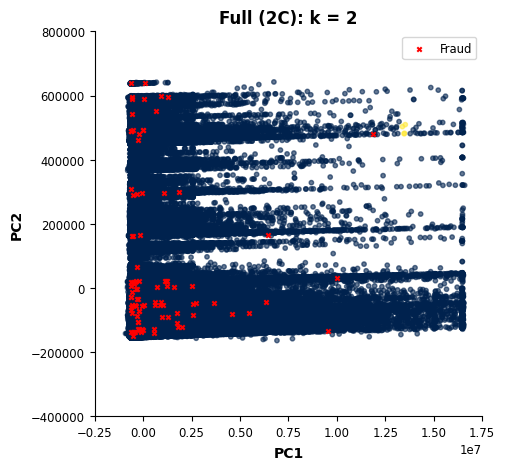

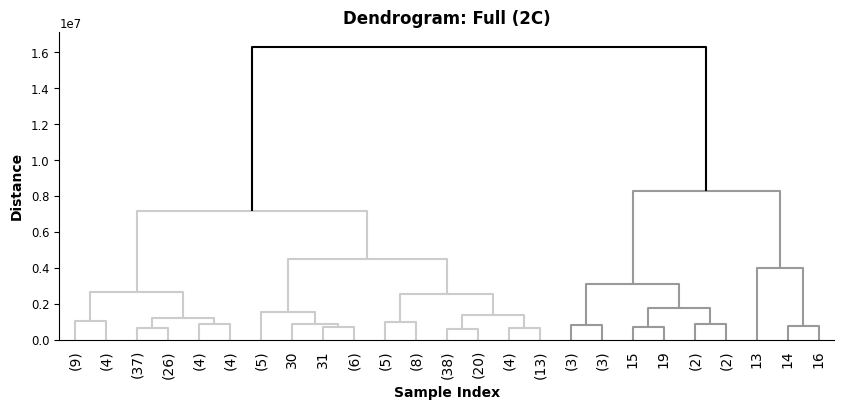


 Full (3C): Running Agglomerative Clustering (k=2)

 Running Agglomerative Clustering for: Full (3C) | Shape: (940481, 3)
 Saved: labels_hier_full_3c.npy | Silhouette=0.9161867594939985, DBI=0.14650451135262293

 Hierarchical clustering complete for all configurations.


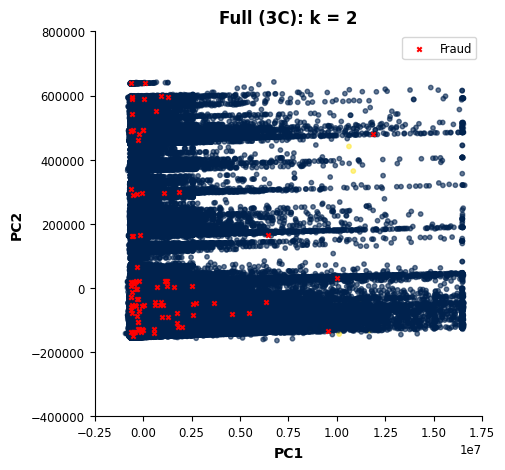

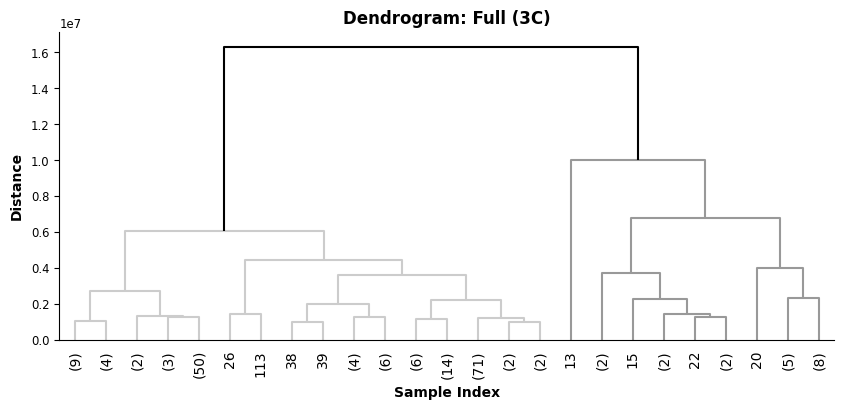


 Key (2C): Running Agglomerative Clustering (k=2)

 Running Agglomerative Clustering for: Key (2C) | Shape: (968524, 2)
 Saved: labels_hier_key_2c.npy | Silhouette=0.33000068794189896, DBI=0.4323889059955696

 Hierarchical clustering complete for all configurations.


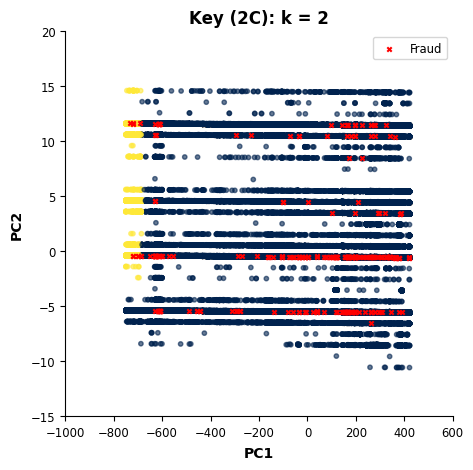

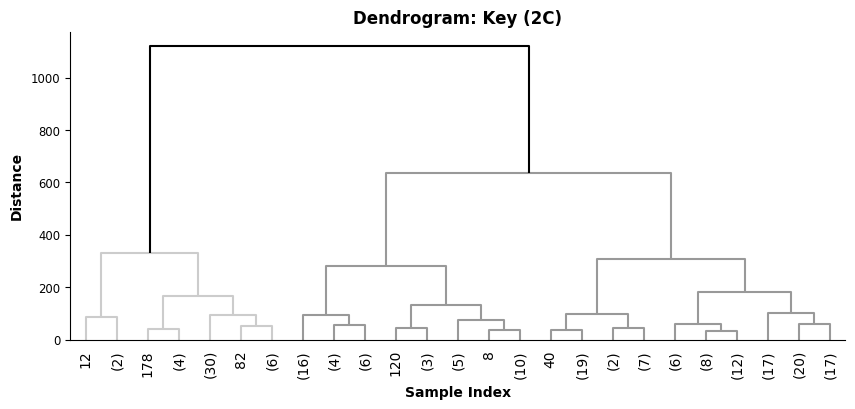


 Key (3C): Running Agglomerative Clustering (k=2)

 Running Agglomerative Clustering for: Key (3C) | Shape: (968524, 3)
 Saved: labels_hier_key_3c.npy | Silhouette=-0.19735807530917157, DBI=5.320741263270202

 Hierarchical clustering complete for all configurations.


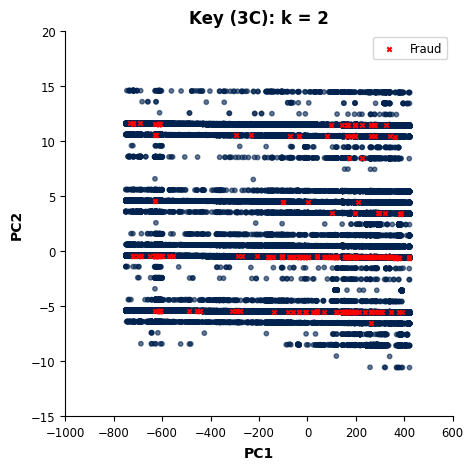

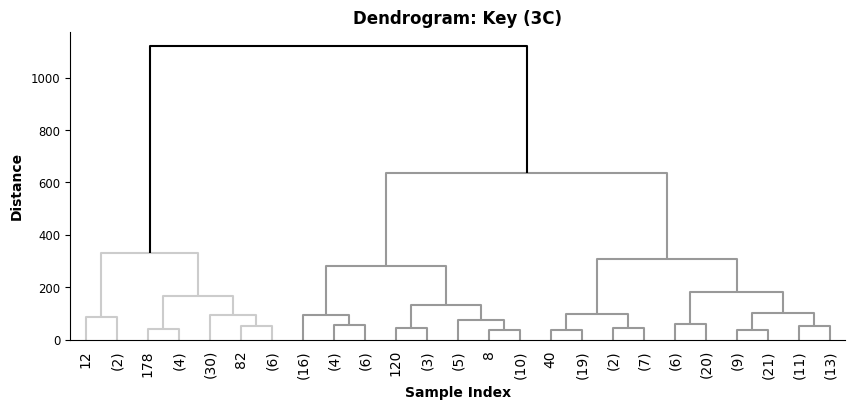

In [19]:
# Cell 6: Run full hierarchical clustering workflow

base_dir = "/content/drive/MyDrive/NCU/Dissertation/Data/Processed/Clustering"
output_dir = os.path.join(base_dir, "Hierarchical")
figure_dir = "/content/drive/MyDrive/NCU/Dissertation/Figures/HierarchicalPlots"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(figure_dir, exist_ok=True)

results_path = os.path.join(output_dir, "hierarchical_results.json")
data = load_hierarchical_data(base_dir)

# Configuration map: (pca_key, y_key, k)
configurations = {
    "Full (2C)": ("x_all_pca_2", "y_all", 2),
    "Full (3C)": ("x_all_pca_3", "y_all", 2),
    "Key (2C)": ("x_key_pca_2", "y_key", 2),
    "Key (3C)": ("x_key_pca_3", "y_key", 2),
}

for label, (x_key, y_key, k) in configurations.items():
    x = data[x_key]
    y = data[y_key]

    print(f"\n {label}: Running Agglomerative Clustering (k={k})")

    # Run clustering and save results/metrics/labels
    run_hierarchical_clustering_all(
        input_dict={label: x},
        output_dir=output_dir,
        result_path=results_path,
        n_clusters=k
    )

    # Load labels we just saved
    label_file = f"labels_hier_{label.lower().replace(' ', '_').replace('(', '').replace(')', '')}.npy"
    label_path = os.path.join(output_dir, label_file)
    labels = np.load(label_path)

    # Plot 2D projection
    proj_path = os.path.join(figure_dir, f"hierarchical_projection_{label.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png")
    plot_cluster_projection(x, y, labels, title=f"{label}: k = {k}", save_path=proj_path)

    # Plot dendrogram (uses CPU, not GPU)
    dendro_path = os.path.join(figure_dir, f"hierarchical_dendrogram_{label.lower().replace(' ', '_').replace('(', '').replace(')', '')}.png")
    plot_dendrogram(x, label=label, save_path=dendro_path)
